# Clasificación mediante árboles de decisión

Este notebook contiene los pasos necesarios para realizar una clasificación usando árboles de decisión con scikit-learn.

In [22]:
# 1. Initial Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

sns.set(style="whitegrid")


In [23]:
# 2. Load dataset and normalize column names
df = pd.read_csv('../data/estaciones_madrid.csv')
df.columns = df.columns.str.strip().str.lower().str.replace('á', 'a') \
                       .str.replace('é', 'e').str.replace('í', 'i') \
                       .str.replace('ó', 'o').str.replace('ú', 'u')

# Display column names and the station with the most records
print("Columns:", df.columns)
print("\nRecords per station:")
print(df['estacion'].value_counts())


Columns: Index(['ano', 'mes', 'dia', 'municipio', 'estacion', 'so2', 'co', 'no', 'no2',
       'pm2.5', 'pm10', 'nox', 'o3', 'tol', 'ben', 'ebe'],
      dtype='object')

Records per station:
estacion
16    334
27    334
18    334
17    334
40    334
39    334
36    334
35    334
59    334
58    334
56    334
57    334
49    334
48    334
54    334
50    334
60    334
47    333
11    333
38    332
8     330
55    329
24    317
4     266
Name: count, dtype: int64


In [24]:
# 3. Filter by station with the most records
most_frequent_station = df['estacion'].value_counts().idxmax()
print(f"Working with station: {most_frequent_station}")
df = df[df['estacion'] == most_frequent_station].copy()

Working with station: 16


Valid NO2 values: 334


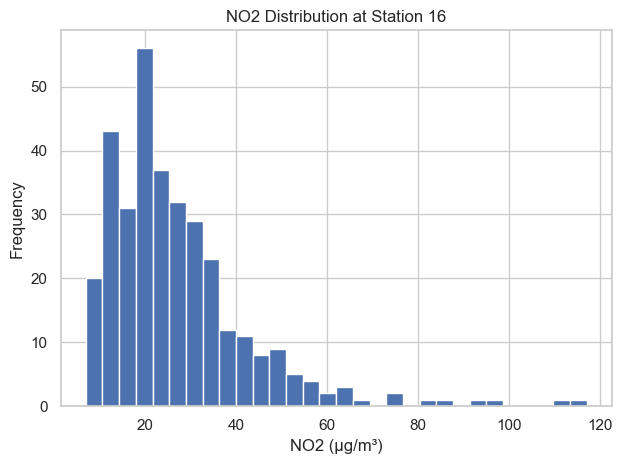

In [25]:
# 4. Visualization of NO2 distribution
print("Valid NO2 values:", df['no2'].notna().sum())
df['no2'].dropna().hist(bins=30)
plt.title('NO2 Distribution at Station 16')
plt.xlabel('NO2 (µg/m³)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('../outputs/no2_distribution_station.png')
plt.show()
plt.close()

In [26]:
# 5. Discretization of NO2 into 3 classes
df = df[df['no2'].notna()].copy()
discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
df['no2_class'] = discretizer.fit_transform(df[['no2']])
df['no2_class'] = df['no2_class'].astype(int)

print("NO2 class distribution:")
print(df['no2_class'].value_counts())

NO2 class distribution:
no2_class
2    115
1    112
0    107
Name: count, dtype: int64


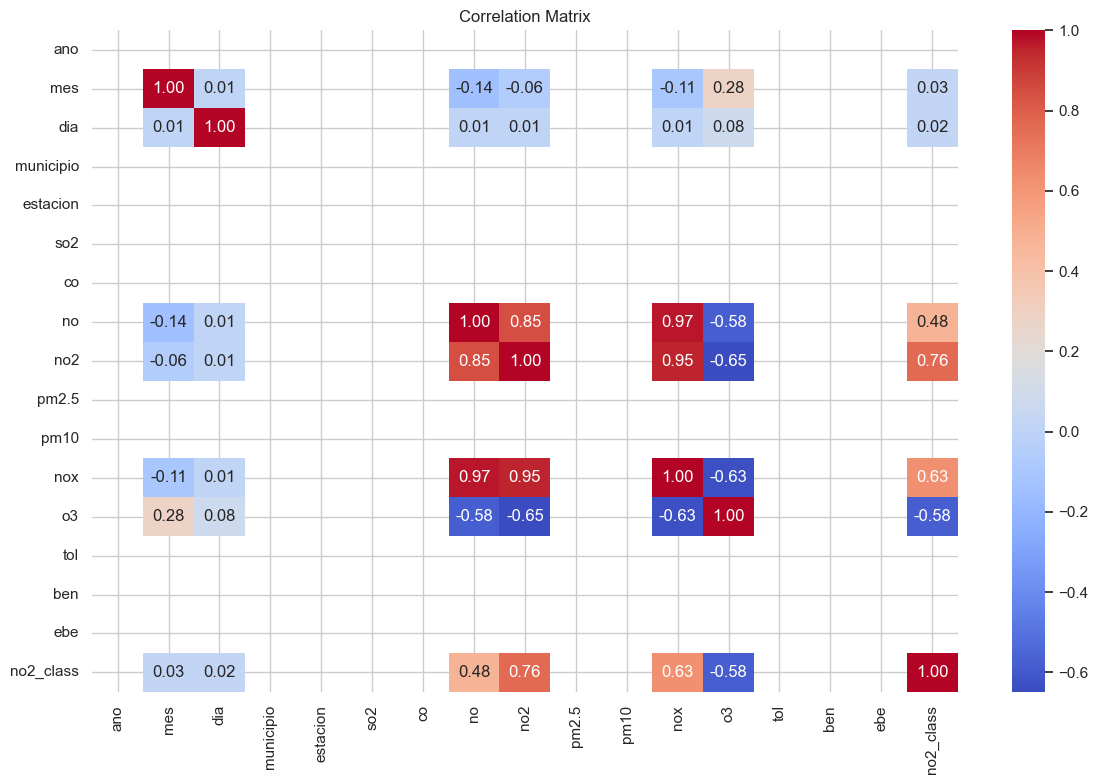

In [27]:
# Calculate the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.savefig('../outputs/correlation_matrix.png')
plt.show()
plt.close()


In [28]:
# Predictor variables
features = ['no', 'nox', 'pm10', 'co']
X = df[features]
y = df['no2_class']

# Split into training and test sets (80/20)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display dataset sizes
print("Training set size:", len(X_train))
print("Test set size:", len(X_test))



Training set size: 267
Test set size: 67


In [29]:
# Train Decision Tree model
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Evaluate on test set
y_pred = clf.predict(X_test)



Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.89      0.91        18
           1       0.87      0.95      0.91        21
           2       1.00      0.96      0.98        28

    accuracy                           0.94        67
   macro avg       0.94      0.94      0.94        67
weighted avg       0.94      0.94      0.94        67



<Figure size 600x500 with 0 Axes>

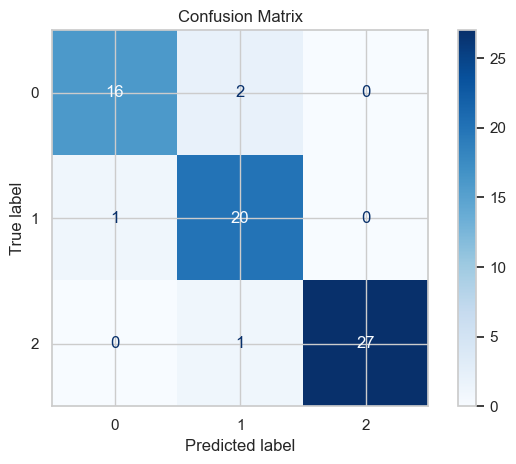

In [30]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)

plt.figure(figsize=(6, 5))  # Ensure the figure is properly initialized
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig('../outputs/confusion_matrix.png')
plt.show()
plt.close()



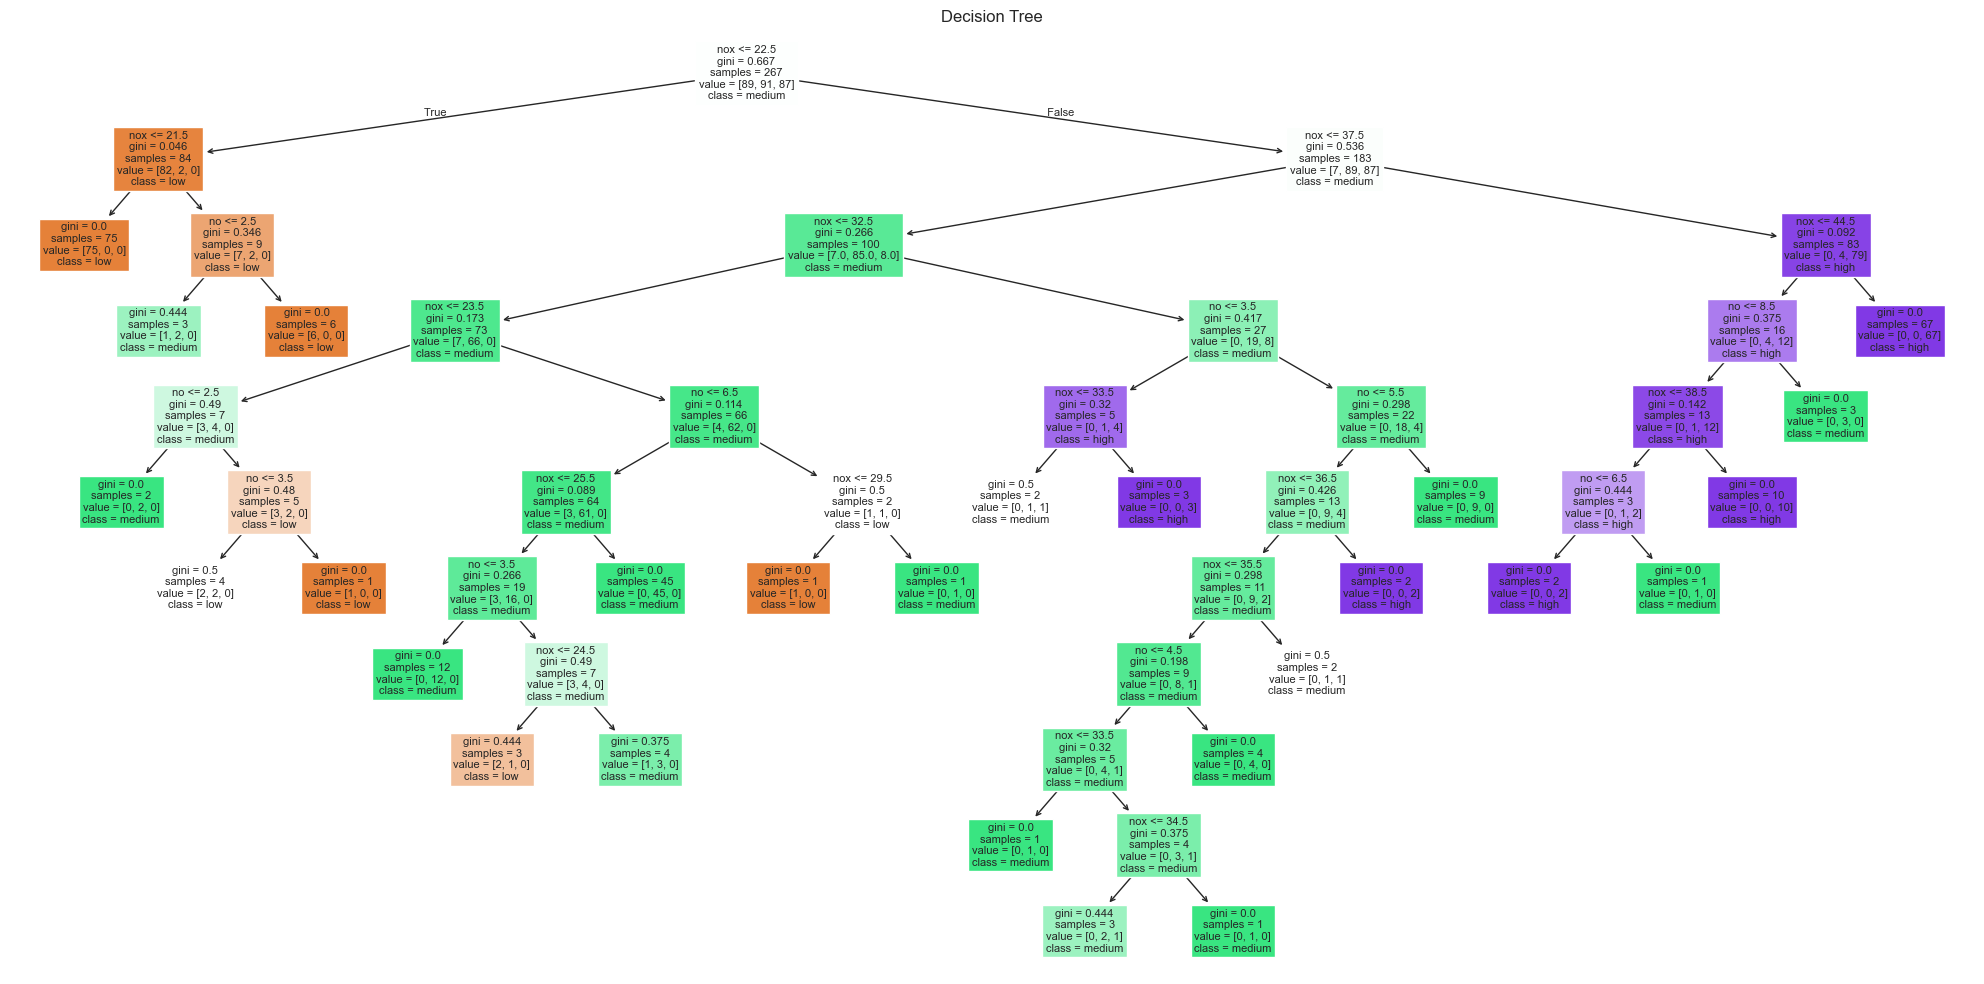

In [31]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(clf, feature_names=features, class_names=["low", "medium", "high"], filled=True)
plt.title("Decision Tree")
plt.tight_layout()
plt.savefig('../outputs/decision_tree_plot.png')
plt.show()
plt.close()



Classification report without 'nox':
              precision    recall  f1-score   support

           0       0.68      0.94      0.79        18
           1       0.63      0.57      0.60        21
           2       0.96      0.79      0.86        28

    accuracy                           0.76        67
   macro avg       0.76      0.77      0.75        67
weighted avg       0.78      0.76      0.76        67



<Figure size 600x500 with 0 Axes>

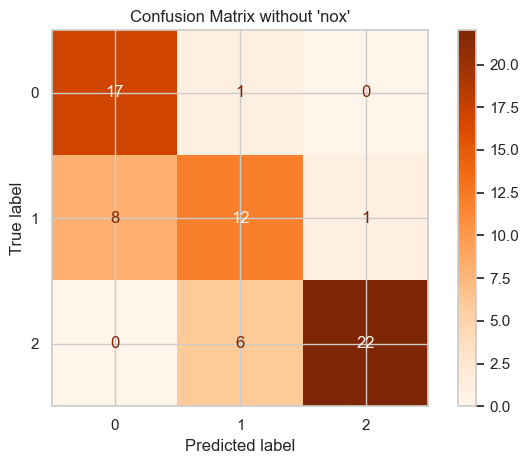

In [32]:
# New set of features without 'nox'
features_without_nox = ['no', 'pm10', 'co']
X2 = df[features_without_nox]
y2 = df['no2_class']

# New train-test split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Train new model
clf2 = DecisionTreeClassifier(random_state=42)
clf2.fit(X2_train, y2_train)

# Predictions and evaluation
y2_pred = clf2.predict(X2_test)

print("Classification report without 'nox':")
print(classification_report(y2_test, y2_pred))

# Confusion matrix
cm2 = confusion_matrix(y2_test, y2_pred)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=clf2.classes_)

plt.figure(figsize=(6, 5))
disp2.plot(cmap='Oranges')
plt.title("Confusion Matrix without 'nox'")
plt.tight_layout()
plt.savefig('../outputs/confusion_matrix_without_nox.png')
plt.show()
plt.close()

Classification report - Random Forest:
              precision    recall  f1-score   support

           0       0.94      0.89      0.91        18
           1       0.87      0.95      0.91        21
           2       1.00      0.96      0.98        28

    accuracy                           0.94        67
   macro avg       0.94      0.94      0.94        67
weighted avg       0.94      0.94      0.94        67



<Figure size 600x500 with 0 Axes>

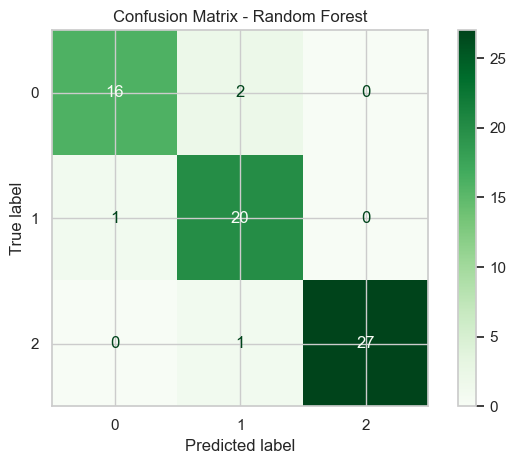

In [33]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest model using all 4 features (including 'nox')
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predictions and evaluation
y_pred_rf = rf.predict(X_test)

print("Classification report - Random Forest:")
print(classification_report(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf.classes_)

plt.figure(figsize=(6, 5))
disp_rf.plot(cmap='Greens')
plt.title("Confusion Matrix - Random Forest")
plt.tight_layout()
plt.savefig('../outputs/confusion_matrix_random_forest.png')
plt.show()
plt.close()